In [1]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install torch==2.0.1+cu118 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB ? eta 0:00:00a 0:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 27.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+rocm5.6
    Uninstalling torch-2.1.0+rocm5.6:
      Successfully uninstalled torch-2.1.0+rocm5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.6.5 requires protobuf<=3.20.1, but you have protobuf 3.20.3 which is incompatible.
pytorch-lightning 1.6.5 requires PyYAML>=5.4, but you have pyyaml 5.3.1 which is incompatible.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 2.0.1+cu118 which is incompatible.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 2.0.1+cu118 which is incompatible.

[notice] A new releas

In [3]:
!pip install blackjax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 6.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 9.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.14
    Uninstalling jaxlib-0.4.14:
      Successfully uninstalled jaxlib-0.4.14
  Attempting uninstall: jax
    Found existing installation: jax 0.4.14
    Uninstalling jax-0.4.14:
      Successfully uninstalled jax-0.4.14
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.7.2 requires PyYAML>=5.4.1, but you have pyyaml 5.3.1 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip 

In [1]:
from typing import Union

import chex
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchsde

from typing import Tuple, Optional

import jax.numpy as jnp
import chex

from typing import Callable

from functools import partial

import chex
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.stats import multivariate_normal

import blackjax
import blackjax.smc.resampling as resampling


def get_senders_and_receivers_fully_connected(n_nodes: int) -> Tuple[chex.Array, chex.Array]:
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x: torch.Tensor, epsilon: float = 1.0, tau: float = 1.0, r: Union[float, chex.Array] = 1.0,
           harmonic_potential_coef: float = 0.5) -> chex.Array:
    n_nodes, dim = x.shape
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    # For harmonic potential see https://github.com/vgsatorras/en_flows/blob/main/deprecated/eqnode/test_systems.py#L94.
    # This oscillator is mentioned but not explicity specified in the paper where it was introduced:
    # http://proceedings.mlr.press/v119/kohler20a/kohler20a.pdf.
    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob_fn(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception


def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = torch.linalg.norm(samples[:, 0, dim] - samples[:, 1, dim], dim=-1)
    
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)
    
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(
        cond, one_step, (0, initial_state, rng_key)
    )

    return n_iter, final_state

def prior_log_prob(x: chex.Array, scale: float = 1.):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d)*scale)


def run_smc_molecule(
        target_log_prob: Callable,
        key: chex.PRNGKey,
        dim: int,
        n_nodes: int,
        n_samples: int,
        num_mcmc_steps: int,
        base_scale: float = 1.,
        target_ess: float = 0.5,
        hmc_step_size: float = 1e-4):
    def flatten(x: chex.Array) -> chex.Array:
        return jnp.reshape(x, (*x.shape[:-2], dim*n_nodes))

    def unflatten(x: chex.Array) -> chex.Array:
        return jnp.reshape(x, (*x.shape[:-1], n_nodes, dim))

    def flat_log_prob_fn(x: chex.Array) -> chex.Array:
        """Takes in flat x."""
        return target_log_prob(unflatten(x))

    flat_dim = dim * n_nodes
    smc_samples = run_smc(
        flat_log_prob_fn,
        key,
        flat_dim,
        n_samples,
        num_mcmc_steps,
        target_ess=target_ess,
        base_scale=base_scale,
        hmc_step_size=hmc_step_size)

    samples = unflatten(smc_samples.particles)
    return samples, smc_samples.weights, smc_samples.lmbda


def run_smc(
        target_log_prob: Callable,
        key: chex.PRNGKey,
        dim: int,
        n_samples: int,
        num_mcmc_steps: int,
        base_scale: float = 1.,
        target_ess: float = 0.5,
        hmc_step_size: float = 1e-4):

    inv_mass_matrix = jnp.eye(dim)

    hmc_parameters = dict(
        step_size=hmc_step_size, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1
    )

    base_log_prob = partial(prior_log_prob, scale=base_scale)
    tempered = blackjax.adaptive_tempered_smc(
        base_log_prob,
        target_log_prob,
        blackjax.mcmc.hmc.build_kernel(),
        blackjax.mcmc.hmc.init,
        hmc_parameters,
        resampling_fn=resampling.systematic,
        target_ess=target_ess,
        num_mcmc_steps=num_mcmc_steps,
    )

    initial_smc_state = jax.random.multivariate_normal(
        jax.random.PRNGKey(0), jnp.zeros([dim,]), jnp.eye(dim), (n_samples,)
    ) * base_scale
    initial_smc_state = tempered.init(initial_smc_state)

    n_iter, smc_samples = smc_inference_loop(key, tempered.step, initial_smc_state)
    return smc_samples


In [2]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        # pdb.set_trace()
        t = t.repeat(len(x)).to(x.device)
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5) #+ 0.1

def estimate_grad_Rt(x, t, beta=1.0, num_mc_samples=100):
    def grad_fxn(_x, _t):
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        h_t = beta * repeated_t
        
        # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * h_t.unsqueeze(1) ** 0.5
        log_rewards = log_prob_fn(samples)#unnormalize(samples, global_mins, global_maxs))
        
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores

In [3]:
def est_ve_score_wrapper(x, t):
    with torch.enable_grad():
        est_score = estimate_grad_Rt(x, t, beta=beta, num_mc_samples=100)
        return est_score

ve_sde_est_score = VEReverseSDE(est_ve_score_wrapper)

beta = 5

dim = 13 * 3
device = 'cuda'
centers = torch.zeros((1000, dim), device=device)
x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=beta))

In [4]:
t = torch.linspace(0.0, 1.0, 500)
with torch.no_grad():
    est_samples = torchsde.sdeint(ve_sde_est_score, x1_samples, t, method='euler')

In [5]:
diffs = est_samples[-1].reshape(-1,13,3)[:,0,(0,1)] - est_samples[-1].reshape(-1,13,3)[:,1,(0,1)]
est_samples[-1, 734].reshape(-1,13,3)

reshaped_est_samples = est_samples[-1].reshape(-1,13,3)
bad_idx = ((reshaped_est_samples[:,0].abs() > 10).any(dim=-1) | (reshaped_est_samples[:,1].abs() > 10).any(dim=-1) )

Text(0.5, 1.0, 'Iteratomic distance apparently?')

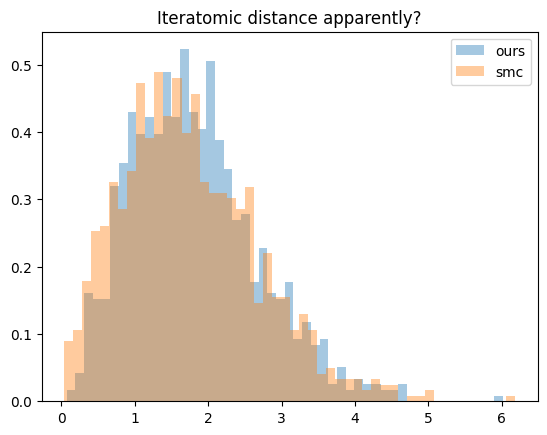

In [10]:
fig, ax = plt.subplots()  # 2D
plot_sample_hist(est_samples[-1].reshape(-1, 13, 3)[~bad_idx].detach().cpu(), ax=ax, label='ours')
#plot_sample_hist(x1_samples.reshape(-1, 13, 3)[~bad_idx].detach().cpu(), ax=ax, label='x1 samples')
plot_sample_hist(smc_samples.cpu(), ax=ax, label='smc')
plt.legend()
plt.title('Iteratomic distance apparently?')


#ax.plot(d, jnp.exp(log_probs - 1))  # approx normalise

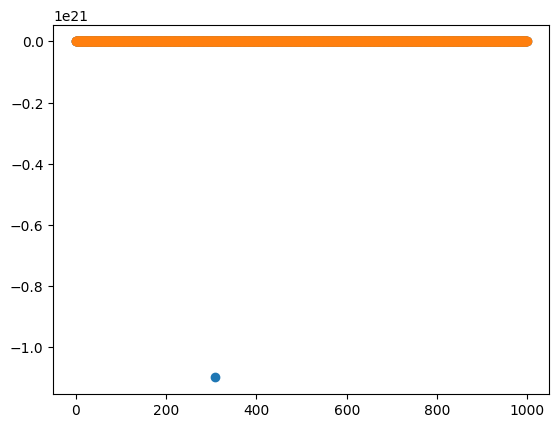

In [11]:
plt.plot(est_samples_lp, 'o')
plt.plot(smc_samples_lp, 'o')

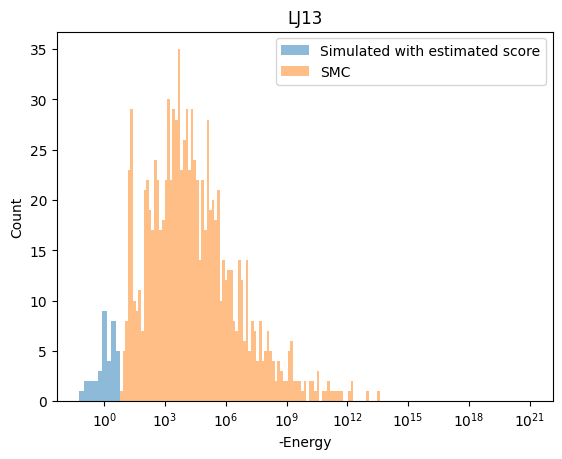

In [12]:
est_samples_0 = est_samples[-1]
smc_samples = torch.tensor(np.array(samples), device=device)

est_samples_lp = log_prob_fn(est_samples_0).detach().cpu()
smc_samples_lp = log_prob_fn(smc_samples).detach().cpu()

plt.hist(
    est_samples_lp,
    alpha=0.5,
    bins=np.logspace(np.log10(est_samples_lp.abs().min()), np.log10(est_samples_lp.abs().max()), 100),
    label='Simulated with estimated score'
)
plt.hist(
    smc_samples_lp.abs(), 
    alpha=0.5, 
    bins=np.logspace(np.log10(smc_samples_lp.abs().min()), np.log10(smc_samples_lp.abs().max()), 100), 
    label='SMC'
)

plt.xscale('log')
plt.ylabel('Count')
plt.xlabel('-Energy')
plt.title('LJ13')
plt.legend()

In [215]:
smc_samples_lp.abs()

tensor(5.8588e+10)

In [138]:
smc_samples_lp

tensor([-3.3522e+02, -1.4210e+04, -5.3542e+04, -1.0584e+10, -4.1170e+03,
        -1.2884e+06, -4.1817e+06, -5.8350e+16, -8.6112e+04, -5.0516e+08,
        -2.0052e+01, -9.0247e+04, -2.7419e+05, -2.5855e+04, -4.6711e+04,
        -1.4489e+02, -1.9280e+04, -6.9404e+02, -1.7027e+01, -1.5973e+03,
        -2.1223e+05, -2.7718e+03, -4.0120e+02, -2.8895e+03, -4.3178e+02,
        -1.1252e+07, -7.7932e+04, -1.5212e+04, -7.0799e+04, -6.3572e+02,
        -2.2479e+06, -1.4408e+03, -3.8081e+02, -7.2641e+04, -1.7686e+04,
        -3.8200e+02, -1.4426e+05, -1.2718e+04, -1.6543e+04, -7.0244e+03,
        -1.2201e+07, -1.3214e+07, -2.8531e+06, -4.7002e+06, -7.3536e+08,
        -5.7078e+02, -1.1016e+04, -2.6766e+04, -1.7516e+07, -3.5987e+03,
        -4.0572e+07, -8.8896e+07, -8.1756e+03, -2.7879e+03, -5.6960e+06,
        -4.8951e+03, -1.3463e+06, -3.2949e+08, -5.2719e+03, -1.5487e+06,
        -4.4588e+05, -6.6545e+05, -1.0004e+02, -2.4385e+02, -3.5649e+08,
        -2.1582e+02, -8.0321e+05, -9.5126e+03, -2.4

In [123]:
torch.tensor(np.array(samples))

tensor([[[ -4.1218,  -1.5818,  -9.3730],
         [  5.0103,   4.5482,   2.8843],
         [  6.4602,   6.5949,   9.6423],
         ...,
         [  7.1010,   3.0208,  -0.2654],
         [  3.9934, -12.1970,  -4.5648],
         [ -4.0445,   5.6971,   4.4362]],

        [[-11.3702,   0.4036,  -4.6541],
         [  0.2584,   0.1562,   2.0209],
         [  4.7249,  -5.8982,  -8.0995],
         ...,
         [  0.3316,   7.4134,   0.6332],
         [ 10.3227,  -4.0148,  -5.0657],
         [  2.4229,   3.6988,  -3.7625]],

        [[ -1.2819,  13.2345,   4.8614],
         [ 10.6261,  -3.2170, -12.0486],
         [ -4.1514,  -2.3411,  -4.5084],
         ...,
         [  2.5606,   1.5298,   8.3366],
         [ -1.3667,  -2.4763,  -0.3970],
         [  0.2337,  -1.1981,  -8.0600]],

        ...,

        [[  4.5645,  -0.0797,  -1.4166],
         [  2.4195,   1.0141,   4.3239],
         [  4.9978,  -1.6444,   4.3870],
         ...,
         [  7.0428,  -2.6684,   6.0581],
         [ -3.9009,   

In [109]:
est_samples_0.reshape(-1, 13, 3)

tensor([[[-1.0959,  2.9030, -5.1397],
         [-0.9339,  4.5374, -7.6722],
         [-2.1438,  2.8176, -6.9319],
         ...,
         [-1.6595,  4.4968, -6.0907],
         [-3.3123,  4.0339, -5.6742],
         [-0.5973,  5.1037, -6.7160]],

        [[-3.4641, -1.5304,  3.1027],
         [-4.2138,  1.1820,  2.5300],
         [-5.4882,  0.8081,  2.3202],
         ...,
         [-5.7435, -0.5974,  4.0782],
         [-3.2204, -0.0174,  1.7840],
         [-3.0856, -2.5560,  5.1176]],

        [[-3.6307,  1.9870,  1.9488],
         [-2.9257,  3.8326,  1.6688],
         [-1.9883,  2.5944,  3.1106],
         ...,
         [-4.0501,  1.0360,  0.3691],
         [-1.8686,  3.1505, -0.2883],
         [-2.6128,  2.9613,  1.4875]],

        ...,

        [[-6.5571, -5.8476, -2.6868],
         [-4.8799, -4.1597, -0.0152],
         [-5.3328, -4.4888,  0.8549],
         ...,
         [-5.9060, -8.1563,  1.9015],
         [-7.9849, -5.0053, -0.4264],
         [-5.9600, -4.7928, -1.0187]],

        [[

[[-113.60253 -113.60253]
 [ 113.60253  113.60253]]


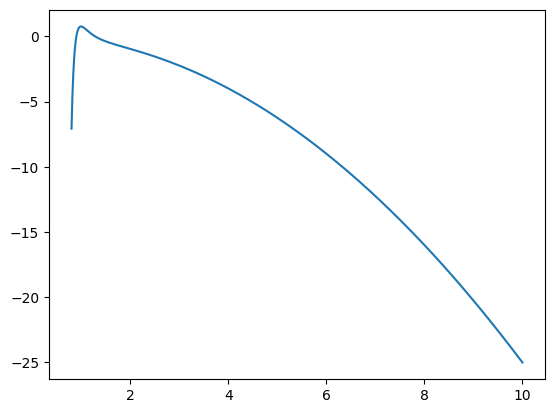

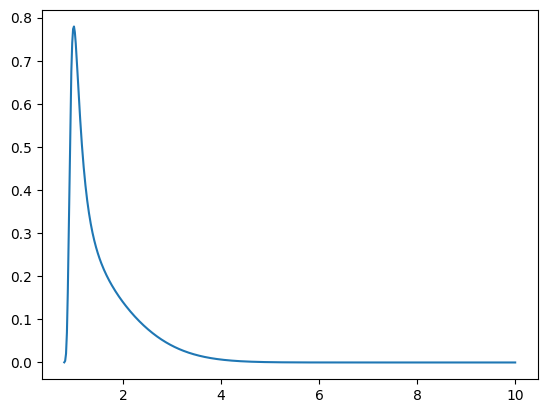

In [8]:
def get_senders_and_receivers_fully_connected_jax(n_nodes: int) -> Tuple[chex.Array, chex.Array]:
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return jnp.array(senders), jnp.array(receivers)

def safe_norm(x: jnp.ndarray, axis: int = None, keepdims=False) -> jnp.ndarray:
    """nan-safe norm. Copied from mace-jax"""
    x2 = jnp.sum(x**2, axis=axis, keepdims=keepdims)
    return jnp.where(x2 == 0, 1, x2) ** 0.5

def energy_jax(x: chex.Array, epsilon: float = 1.0, tau: float = 1.0, r: Union[float, chex.Array] = 1.0,
           harmonic_potential_coef: float = 0.5) -> chex.Array:
    chex.assert_rank(x, 2)
    n_nodes, dim = x.shape
    if isinstance(r, float):
        r = jnp.ones(n_nodes) * r
    senders, receivers = get_senders_and_receivers_fully_connected_jax(n_nodes)
    vectors = x[senders] - x[receivers]
    d = safe_norm(vectors, axis=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * jnp.sum(term_inside_sum)

    # For harmonic potential see https://github.com/vgsatorras/en_flows/blob/main/deprecated/eqnode/test_systems.py#L94.
    # This oscillator is mentioned but not explicity specified in the paper where it was introduced:
    # http://proceedings.mlr.press/v119/kohler20a/kohler20a.pdf.
    centre_of_mass = jnp.mean(x, axis=0)
    harmonic_potential = harmonic_potential_coef*jnp.sum((x - centre_of_mass)**2)
    return energy + harmonic_potential


def log_prob_fn_jax(x: chex.Array):
    if len(x.shape) == 2:
        return - energy_jax(x)
    elif len(x.shape) == 3:
        return - jax.vmap(energy_jax)(x)
    else:
        raise Exception

# Visualise 2D energy fn as a function of distance
key = jax.random.PRNGKey(0)

dim = 2
batch_size = 512
x0 = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))   #  jnp.zeros((batch_size, 2)) + 0.1
d = jnp.linspace(0.8, 10, batch_size)
x1 = x0 + jnp.sqrt(d**2/2)[:, None]

x = jnp.stack([x0, x1], axis=1)
log_probs = log_prob_fn_jax(x)

print(jax.grad(log_prob_fn_jax)(x[0]))

plt.plot(d, log_probs)
plt.show()

fig, ax = plt.subplots()  # 2D
ax.plot(d, jnp.exp(log_probs - 1))  # approx normalise

n_nodes = 13
dim = 3
samples, weights, lmbda = run_smc_molecule(target_log_prob=log_prob_fn_jax,
                    dim=dim,
                    n_nodes=n_nodes,
                    key=key,
                    n_samples=1000,
                    num_mcmc_steps=1000,
                    target_ess=0.0,
                    base_scale=1.,
                    hmc_step_size= 1e-3)


In [131]:
samples = np.array(samples)

In [132]:
samples

array([[[-0.77883977, -0.30674455, -1.8585678 ],
        [ 0.97510195,  0.9074563 ,  0.6209733 ],
        [ 1.3162862 ,  1.3252476 ,  1.9455532 ],
        ...,
        [ 1.4433706 ,  0.6141487 , -0.05481751],
        [ 0.7746152 , -2.4227786 , -0.92072374],
        [-0.78129524,  1.157335  ,  0.8840191 ]],

       [[-2.235014  ,  0.04662913, -0.91730493],
        [ 0.03822393,  0.01870631,  0.41452697],
        [ 0.9477271 , -1.1734844 , -1.6380315 ],
        ...,
        [ 0.09167233,  1.5187517 ,  0.16287485],
        [ 2.0514297 , -0.80377996, -0.9536698 ],
        [ 0.5174284 ,  0.7041562 , -0.7777535 ]],

       [[-0.2837644 ,  2.684302  ,  0.9646145 ],
        [ 2.1637278 , -0.60731417, -2.4349911 ],
        [-0.8271457 , -0.49624678, -0.9544811 ],
        ...,
        [ 0.53440124,  0.30984372,  1.6306531 ],
        [-0.2494463 , -0.49995238, -0.05971956],
        [ 0.06205076, -0.2683341 , -1.6285921 ]],

       ...,

       [[ 0.9225429 , -0.0328577 , -0.28198117],
        [ 0

In [ ]:
vals = (torch.rand((100, 13, 3), device='cuda') * 20) - 10

In [ ]:
"""Follows https://blackjax-devs.github.io/sampling-book/algorithms/TemperedSMC.html#id2. """
from typing import Callable

from functools import partial

import chex
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.stats import multivariate_normal

import blackjax
import blackjax.smc.resampling as resampling

def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(
        cond, one_step, (0, initial_state, rng_key)
    )

    return n_iter, final_state

def prior_log_prob(x: chex.Array, scale: float = 1.):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d)*scale)


def run_smc_molecule(
        target_log_prob: Callable,
        key: chex.PRNGKey,
        dim: int,
        n_nodes: int,
        n_samples: int,
        num_mcmc_steps: int,
        base_scale: float = 1.,
        target_ess: float = 0.5,
        hmc_step_size: float = 1e-4):
    def flatten(x: chex.Array) -> chex.Array:
        return jnp.reshape(x, (*x.shape[:-2], dim*n_nodes))

    def unflatten(x: chex.Array) -> chex.Array:
        return jnp.reshape(x, (*x.shape[:-1], n_nodes, dim))

    def flat_log_prob_fn(x: chex.Array) -> chex.Array:
        """Takes in flat x."""
        return target_log_prob(unflatten(x))

    flat_dim = dim * n_nodes
    smc_samples = run_smc(
        flat_log_prob_fn,
        key,
        flat_dim,
        n_samples,
        num_mcmc_steps,
        target_ess=target_ess,
        base_scale=base_scale,
        hmc_step_size=hmc_step_size)

    samples = unflatten(smc_samples.particles)
    return samples, smc_samples.weights, smc_samples.lmbda


def run_smc(
        target_log_prob: Callable,
        key: chex.PRNGKey,
        dim: int,
        n_samples: int,
        num_mcmc_steps: int,
        base_scale: float = 1.,
        target_ess: float = 0.5,
        hmc_step_size: float = 1e-4):

    inv_mass_matrix = jnp.eye(dim)

    hmc_parameters = dict(
        step_size=hmc_step_size, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1
    )

    base_log_prob = partial(prior_log_prob, scale=base_scale)
    tempered = blackjax.adaptive_tempered_smc(
        base_log_prob,
        target_log_prob,
        blackjax.hmc.kernel(),
        blackjax.hmc.init,
        hmc_parameters,
        resampling_fn=resampling.systematic,
        target_ess=target_ess,
        num_mcmc_steps=num_mcmc_steps,
    )

    initial_smc_state = jax.random.multivariate_normal(
        jax.random.PRNGKey(0), jnp.zeros([dim,]), jnp.eye(dim), (n_samples,)
    ) * base_scale
    initial_smc_state = tempered.init(initial_smc_state)

    n_iter, smc_samples = smc_inference_loop(key, tempered.step, initial_smc_state)
    return smc_samples


In [ ]:
if __name__ == '__main__':
    USE_64_BIT = False
    if USE_64_BIT:
        from jax.config import config
        config.update("jax_enable_x64", True)


    # Visualise 2D energy fn as a function of distance
    key = jax.random.PRNGKey(0)

    dim = 2
    batch_size = 512
    x0 = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))   #  jnp.zeros((batch_size, 2)) + 0.1
    d = jnp.linspace(0.8, 10, batch_size)
    x1 = x0 + jnp.sqrt(d**2/2)[:, None]

    x = jnp.stack([x0, x1], axis=1)
    log_probs = log_prob_fn(x)

    print(jax.grad(log_prob_fn)(x[0]))

    plt.plot(d, log_probs)
    plt.show()

    fig, ax = plt.subplots()  # 2D
    ax.plot(d, jnp.exp(log_probs - 1))  # approx normalise

    n_nodes = 13
    dim = 3
    samples, weights, lmbda = run_smc_molecule(target_log_prob=log_prob_fn,
                        dim=dim,
                        n_nodes=n_nodes,
                        key=key,
                        n_samples =1000,
                        num_mcmc_steps=30,
                        target_ess=0.0,
                        base_scale=2.,
                        hmc_step_size= 1e-3)

    plot_sample_hist(samples, ax=ax)
    plt.show()

    # make_dataset(dim=3, n_vertices=13)